In [1]:
building_id = 2
price = 100
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 3
price = 200
iteration = 6


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Warehouse New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    40,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

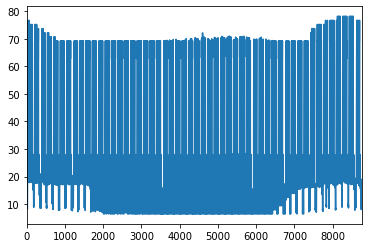

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 10,626.92
78.13965517958043


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 4,598 m²
Roof area is up 70 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 13.873095750808716 sec


0.0


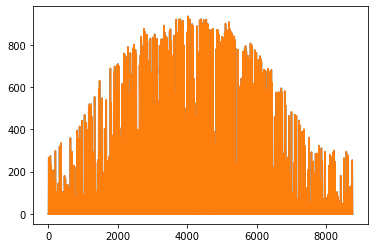

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


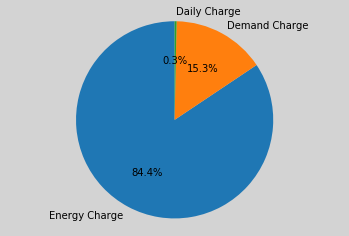

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

261136.0

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    4667.576
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         20723.9
Aug         22065.5
Dec         23271.5
Feb         20983.8
Jan         23774.3
Jul         19933.9
Jun         20611.8
Mar         23584.0
May         21175.7
Nov         22611.0
Oct         21919.2
Sep         20481.3
monthly_import    261135.9
dtype: float64
261136.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 125, 180, 6, 56, 26, 0.8499999999999999, 0.35, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.928886413574219 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29920.6


ERROR:ga_logger:total demand cost: 4480.036


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,743 kWh
At a cost of $ 0.0767 /kWh
Total Cost of the system: $ 29,921 per year


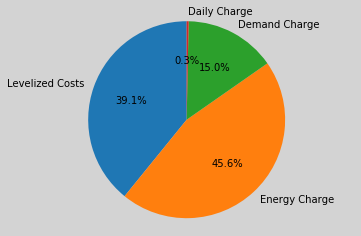

Total roof area of the  building: 4,598 m²
Total roof area used 735 m²
Percentage: 16.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 220, 175, 51, 16, 26, 0.7, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29058.5


ERROR:ga_logger:total demand cost: 4463.089000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,246 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 29,058 per year


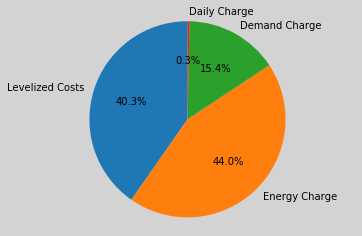

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 175, 185, 46, 11, 6, 0.25, 0.49999999999999994, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29186.1


ERROR:ga_logger:total demand cost: 4480.34


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,588 kWh
At a cost of $ 0.0756 /kWh
Total Cost of the system: $ 29,186 per year


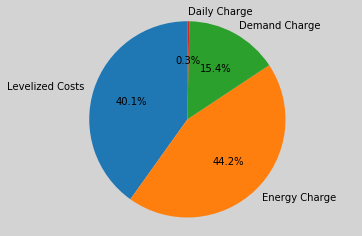

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 130, 230, 11, 46, 41, 0.39999999999999997, 0.8999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30022.8


ERROR:ga_logger:total demand cost: 4452.318


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,467 kWh
At a cost of $ 0.0793 /kWh
Total Cost of the system: $ 30,023 per year


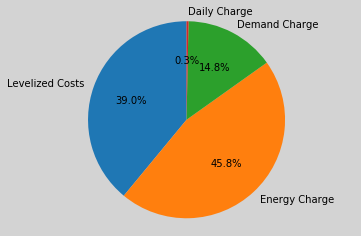

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 190, 125, 36, 21, 26, 0.44999999999999996, 0.5999999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29374.2


ERROR:ga_logger:total demand cost: 4462.714


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,501 kWh
At a cost of $ 0.0755 /kWh
Total Cost of the system: $ 29,374 per year


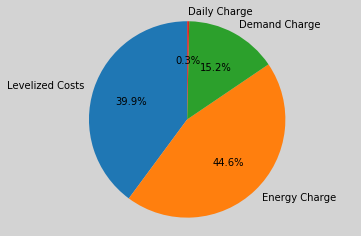

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 260, 200, 41, 16, 16, 0.5999999999999999, 0.5499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29523.4


ERROR:ga_logger:total demand cost: 4488.540999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,162 kWh
At a cost of $ 0.0755 /kWh
Total Cost of the system: $ 29,523 per year


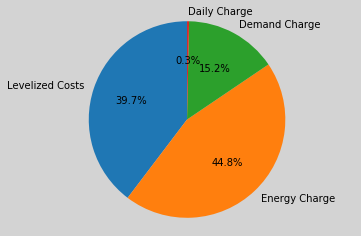

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 210, 255, 16, 41, 46, 0.7999999999999998, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29877.8


ERROR:ga_logger:total demand cost: 4463.025


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,109 kWh
At a cost of $ 0.0777 /kWh
Total Cost of the system: $ 29,878 per year


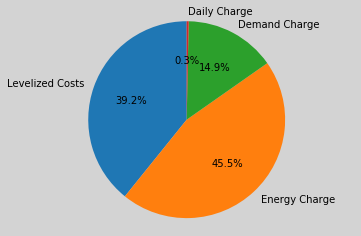

Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 115, 140, 6, 56, 36, 0.5999999999999999, 0.25, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29741.7


ERROR:ga_logger:total demand cost: 4475.313


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,415 kWh
At a cost of $ 0.0780 /kWh
Total Cost of the system: $ 29,742 per year


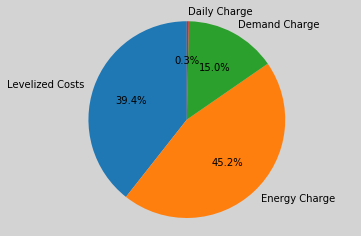

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 225, 245, 31, 46, 46, 0.3, 0.8999999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30453.2


ERROR:ga_logger:total demand cost: 4465.473


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,266 kWh
At a cost of $ 0.0809 /kWh
Total Cost of the system: $ 30,453 per year


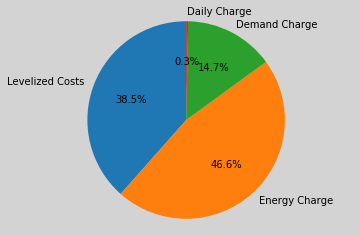

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 225, 260, 36, 46, 36, 0.25, 0.6499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28901.1


ERROR:ga_logger:total demand cost: 4469.465


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,727 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 28,901 per year


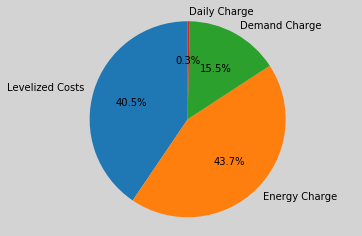

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (105, 100, 220, 51, 26, 31, 0.49999999999999994, 0.7, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 79.4086]


ERROR:ga_logger:Cost: 30479.4


ERROR:ga_logger:total demand cost: 4613.2210000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 246,782 kWh
At a cost of $ 0.0984 /kWh
Total Cost of the system: $ 30,479 per year


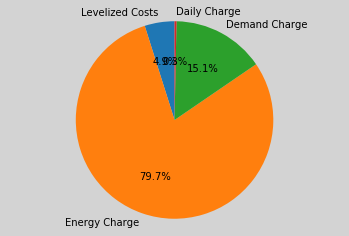

Total roof area of the  building: 4,598 m²
Total roof area used 106 m²
Percentage: 2.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 115, 235, 46, 51, 11, 0.7999999999999998, 0.7499999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.368524074554443 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30458.6


ERROR:ga_logger:total demand cost: 4456.972000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,273 kWh
At a cost of $ 0.0792 /kWh
Total Cost of the system: $ 30,459 per year


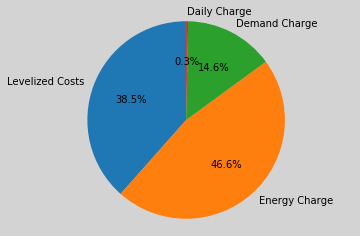

Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 145, 130, 51, 41, 56, 0.49999999999999994, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29465.8


ERROR:ga_logger:total demand cost: 4476.130999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,679 kWh
At a cost of $ 0.0772 /kWh
Total Cost of the system: $ 29,466 per year


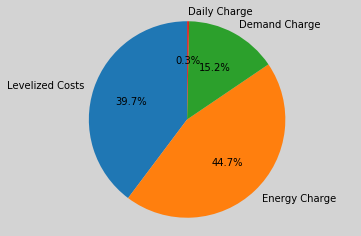

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 235, 215, 11, 11, 21, 0.5999999999999999, 0.3, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29922.9


ERROR:ga_logger:total demand cost: 4453.656000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,833 kWh
At a cost of $ 0.0786 /kWh
Total Cost of the system: $ 29,923 per year


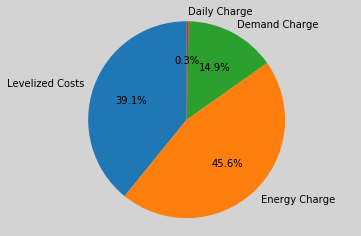

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 170, 120, 21, 11, 46, 0.25, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29305.2


ERROR:ga_logger:total demand cost: 4456.7429999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,463 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 29,305 per year


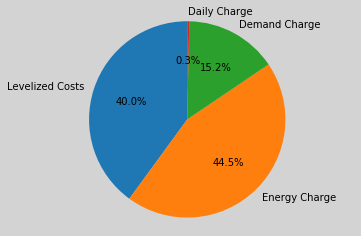

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 125, 240, 46, 36, 11, 0.8999999999999999, 0.39999999999999997, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30163.0


ERROR:ga_logger:total demand cost: 4473.552


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,480 kWh
At a cost of $ 0.0795 /kWh
Total Cost of the system: $ 30,163 per year


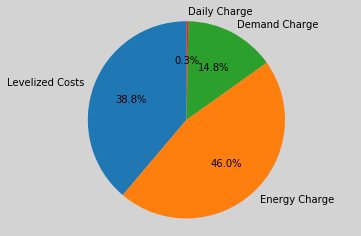

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 125, 235, 6, 51, 31, 0.39999999999999997, 0.44999999999999996, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [32.4859, 0.0, 0.0]


ERROR:ga_logger:Cost: 30482.3


ERROR:ga_logger:total demand cost: 4624.005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 255,097 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,482 per year


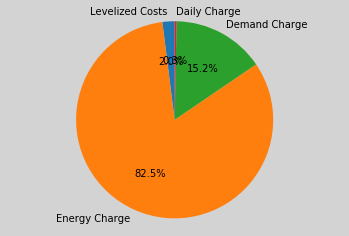

Total roof area of the  building: 4,598 m²
Total roof area used 81 m²
Percentage: 1.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 230, 130, 31, 6, 41, 0.49999999999999994, 0.5999999999999999, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29852.3


ERROR:ga_logger:total demand cost: 4474.483


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,678 kWh
At a cost of $ 0.0786 /kWh
Total Cost of the system: $ 29,852 per year


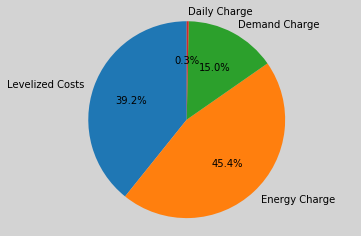

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 95, 245, 21, 31, 16, 0.6499999999999999, 0.8499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30138.0


ERROR:ga_logger:total demand cost: 4463.960999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,368 kWh
At a cost of $ 0.0795 /kWh
Total Cost of the system: $ 30,138 per year


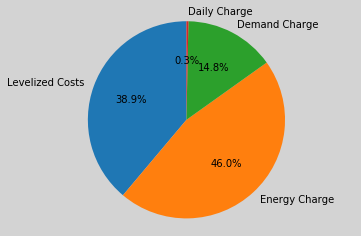

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (200, 205, 135, 46, 46, 6, 0.39999999999999997, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29561.0


ERROR:ga_logger:total demand cost: 4486.378000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,409 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 29,561 per year


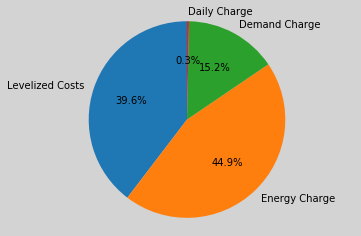

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (200, 180, 230, 11, 21, 21, 0.2, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.959601640701294 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.760844469070435 sec


ERROR:ga_logger:Generated the panel irradiance in  14s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29621.1


ERROR:ga_logger:total demand cost: 4467.692


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,981 kWh
At a cost of $ 0.0763 /kWh
Total Cost of the system: $ 29,621 per year


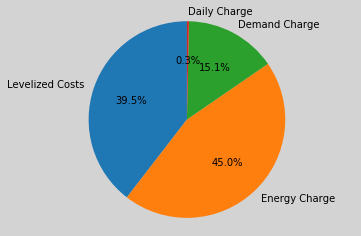

Total roof area of the  building: 4,598 m²
Total roof area used 833 m²
Percentage: 18.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (220, 165, 100, 11, 6, 31, 0.35, 0.25, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30008.2


ERROR:ga_logger:total demand cost: 4452.235


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,618 kWh
At a cost of $ 0.0774 /kWh
Total Cost of the system: $ 30,008 per year


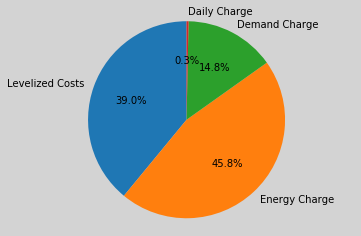

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 195, 195, 46, 16, 36, 0.5999999999999999, 0.7499999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29140.5


ERROR:ga_logger:total demand cost: 4473.854


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 233,708 kWh
At a cost of $ 0.0550 /kWh
Total Cost of the system: $ 29,140 per year


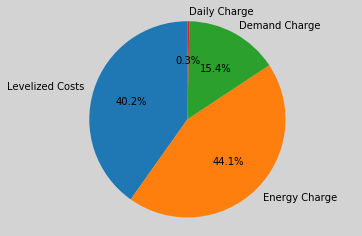

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 110, 260, 36, 36, 26, 0.7999999999999998, 0.5999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29972.3


ERROR:ga_logger:total demand cost: 4491.984


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,526 kWh
At a cost of $ 0.0770 /kWh
Total Cost of the system: $ 29,972 per year


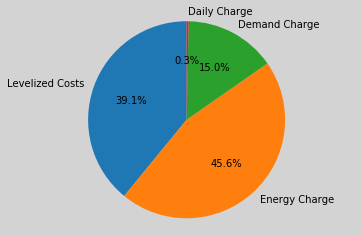

Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 105, 140, 51, 1, 26, 0.8999999999999999, 0.2, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 1.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.660937309265137 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29652.0


ERROR:ga_logger:total demand cost: 4465.339000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,086 kWh
At a cost of $ 0.0777 /kWh
Total Cost of the system: $ 29,652 per year


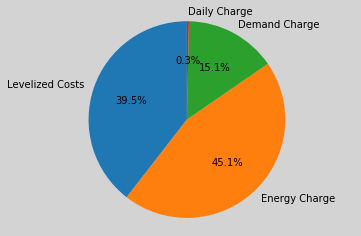

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 105, 255, 26, 6, 46, 0.39999999999999997, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29060.9


ERROR:ga_logger:total demand cost: 4463.108


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,590 kWh
At a cost of $ 0.0745 /kWh
Total Cost of the system: $ 29,061 per year


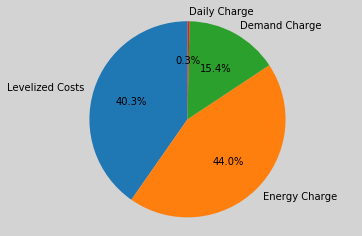

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 150, 150, 1, 31, 41, 0.44999999999999996, 0.3, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29178.0


ERROR:ga_logger:total demand cost: 4465.575


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,810 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,178 per year


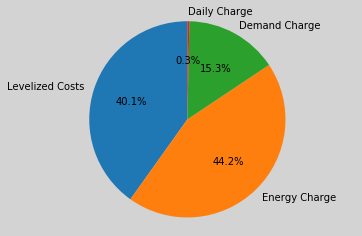

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 195, 245, 56, 1, 56, 0.49999999999999994, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.502875566482544 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [40.2383, 0.0, 0.0]


ERROR:ga_logger:Cost: 30480.8


ERROR:ga_logger:total demand cost: 4625.374


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 253,616 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,481 per year


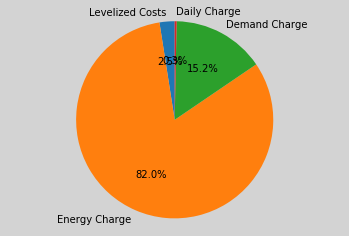

Total roof area of the  building: 4,598 m²
Total roof area used 80 m²
Percentage: 1.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (225, 170, 150, 26, 36, 11, 0.5499999999999999, 0.44999999999999996, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29147.4


ERROR:ga_logger:total demand cost: 4475.444


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,421 kWh
At a cost of $ 0.0750 /kWh
Total Cost of the system: $ 29,147 per year


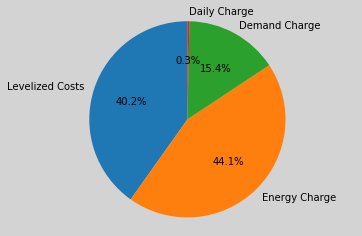

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 240, 245, 6, 16, 21, 0.49999999999999994, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30305.2


ERROR:ga_logger:total demand cost: 4456.9929999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,732 kWh
At a cost of $ 0.0777 /kWh
Total Cost of the system: $ 30,305 per year


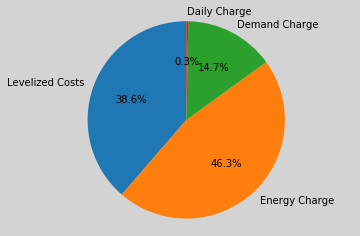

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (105, 195, 245, 6, 56, 11, 0.39999999999999997, 0.7, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30392.8


ERROR:ga_logger:total demand cost: 4452.262


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,606 kWh
At a cost of $ 0.0787 /kWh
Total Cost of the system: $ 30,393 per year


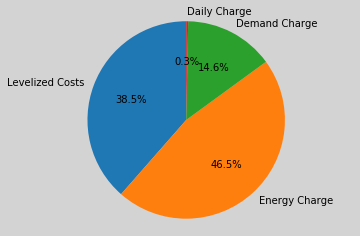

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (90, 165, 250, 26, 11, 16, 0.8999999999999999, 0.3, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 16.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.767133474349976 sec


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29715.0


ERROR:ga_logger:total demand cost: 4451.950000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,180 kWh
At a cost of $ 0.0777 /kWh
Total Cost of the system: $ 29,715 per year


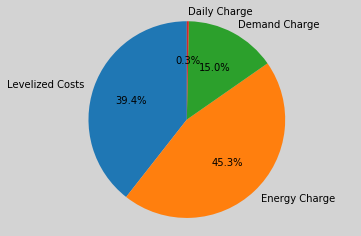

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (105, 170, 120, 51, 36, 6, 0.49999999999999994, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29147.4


ERROR:ga_logger:total demand cost: 4475.444


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,629 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 29,147 per year


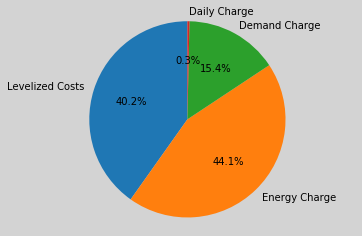

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 255, 235, 41, 1, 46, 0.3, 0.8499999999999999, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29064.1


ERROR:ga_logger:total demand cost: 4476.37


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,319 kWh
At a cost of $ 0.0737 /kWh
Total Cost of the system: $ 29,064 per year


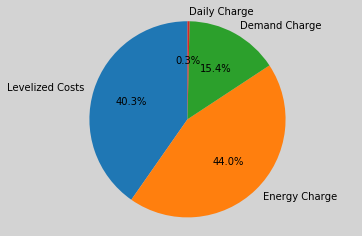

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 240, 255, 26, 1, 6, 0.2, 0.5499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28951.3


ERROR:ga_logger:total demand cost: 4459.683


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,263 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 28,951 per year


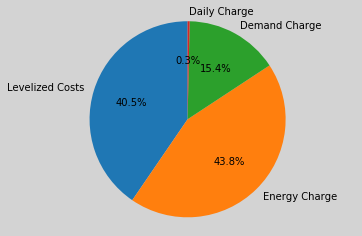

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 210, 185, 51, 46, 1, 0.8999999999999999, 0.39999999999999997, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29811.3


ERROR:ga_logger:total demand cost: 4486.435


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,224 kWh
At a cost of $ 0.0750 /kWh
Total Cost of the system: $ 29,811 per year


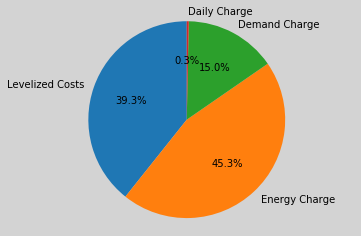

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 180, 235, 16, 6, 11, 0.3, 0.7, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30133.7


ERROR:ga_logger:total demand cost: 4451.4529999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,673 kWh
At a cost of $ 0.0790 /kWh
Total Cost of the system: $ 30,134 per year


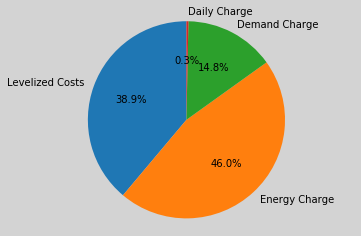

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 185, 185, 1, 16, 36, 0.6499999999999999, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29388.3


ERROR:ga_logger:total demand cost: 4453.966


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,774 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,388 per year


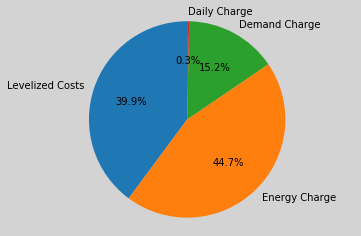

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 205, 110, 36, 21, 51, 0.5999999999999999, 0.49999999999999994, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29470.4


ERROR:ga_logger:total demand cost: 4460.504000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,122 kWh
At a cost of $ 0.0754 /kWh
Total Cost of the system: $ 29,470 per year


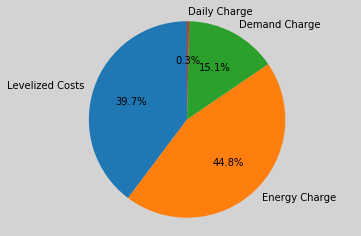

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (120, 130, 165, 41, 46, 56, 0.6499999999999999, 0.39999999999999997, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29654.5


ERROR:ga_logger:total demand cost: 4490.531


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,345 kWh
At a cost of $ 0.0775 /kWh
Total Cost of the system: $ 29,654 per year


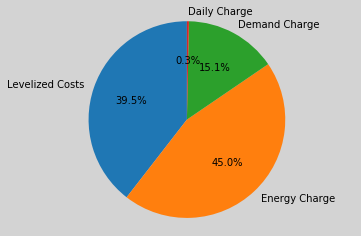

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (260, 245, 120, 11, 26, 51, 0.8499999999999999, 0.3, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.662594795227051 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30383.0


ERROR:ga_logger:total demand cost: 4461.423000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 183,330 kWh
At a cost of $ 0.0770 /kWh
Total Cost of the system: $ 30,383 per year


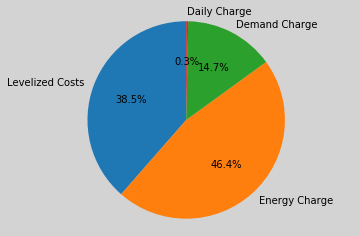

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 130, 240, 31, 36, 16, 0.2, 0.44999999999999996, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28899.3


ERROR:ga_logger:total demand cost: 4463.599


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,627 kWh
At a cost of $ 0.0744 /kWh
Total Cost of the system: $ 28,899 per year


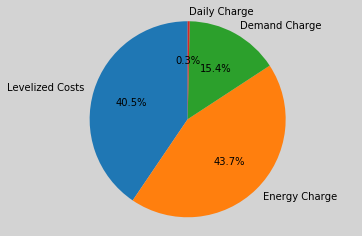

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 255, 195, 11, 26, 1, 0.3, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29943.1


ERROR:ga_logger:total demand cost: 4451.910000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,344 kWh
At a cost of $ 0.0789 /kWh
Total Cost of the system: $ 29,943 per year


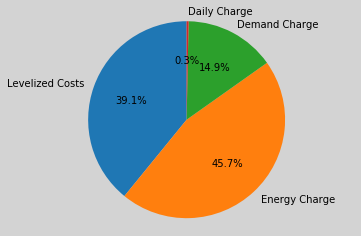

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 110, 120, 31, 41, 6, 0.7, 0.3, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30376.2


ERROR:ga_logger:total demand cost: 4451.183


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,627 kWh
At a cost of $ 0.0804 /kWh
Total Cost of the system: $ 30,376 per year


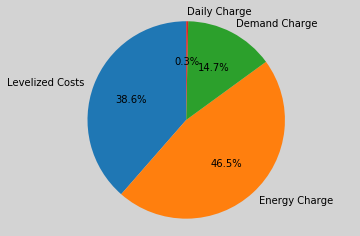

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (170, 90, 150, 1, 6, 36, 0.5499999999999999, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 6.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.25478219985962 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.662132740020752 sec


ERROR:ga_logger:Generated the panel irradiance in  21s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 43.2143]


ERROR:ga_logger:Cost: 30481.8


ERROR:ga_logger:total demand cost: 4623.706999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 253,066 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,482 per year


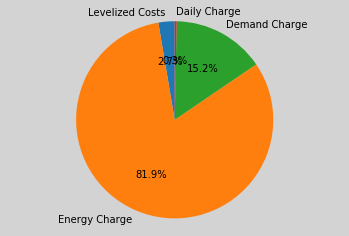

Total roof area of the  building: 4,598 m²
Total roof area used 54 m²
Percentage: 1.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 110, 175, 11, 26, 21, 0.39999999999999997, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29113.5


ERROR:ga_logger:total demand cost: 4456.302


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,129 kWh
At a cost of $ 0.0751 /kWh
Total Cost of the system: $ 29,114 per year


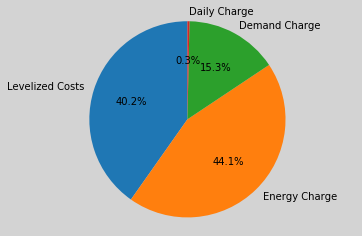

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 180, 125, 56, 16, 46, 0.6499999999999999, 0.8999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30103.3


ERROR:ga_logger:total demand cost: 4467.958


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,282 kWh
At a cost of $ 0.0780 /kWh
Total Cost of the system: $ 30,103 per year


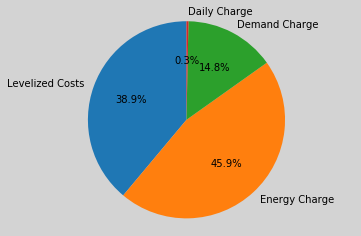

Total roof area of the  building: 4,598 m²
Total roof area used 694 m²
Percentage: 15.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (120, 220, 170, 36, 51, 16, 0.7, 0.7499999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29735.8


ERROR:ga_logger:total demand cost: 4461.238


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,353 kWh
At a cost of $ 0.0772 /kWh
Total Cost of the system: $ 29,736 per year


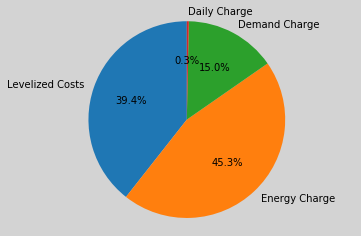

Total roof area of the  building: 4,598 m²
Total roof area used 833 m²
Percentage: 18.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (195, 225, 175, 36, 41, 36, 0.35, 0.3, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29085.7


ERROR:ga_logger:total demand cost: 4472.28


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,946 kWh
At a cost of $ 0.0736 /kWh
Total Cost of the system: $ 29,086 per year


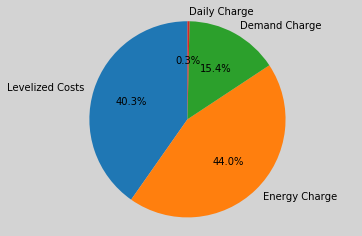

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 215, 195, 21, 26, 1, 0.3, 0.7499999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30174.5


ERROR:ga_logger:total demand cost: 4474.714


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,386 kWh
At a cost of $ 0.0774 /kWh
Total Cost of the system: $ 30,174 per year


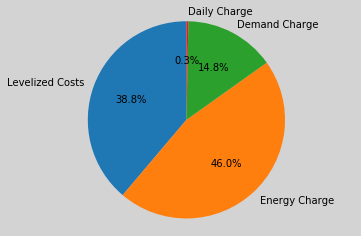

Total roof area of the  building: 4,598 m²
Total roof area used 833 m²
Percentage: 18.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 175, 150, 26, 16, 51, 0.5499999999999999, 0.3, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29382.1


ERROR:ga_logger:total demand cost: 4454.28


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,666 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,382 per year


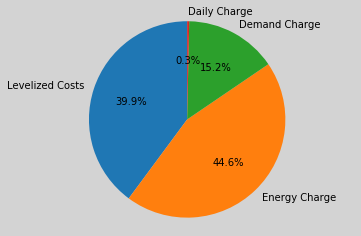

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 265, 110, 36, 56, 36, 0.3, 0.44999999999999996, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28939.5


ERROR:ga_logger:total demand cost: 4470.759999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,500 kWh
At a cost of $ 0.0738 /kWh
Total Cost of the system: $ 28,940 per year


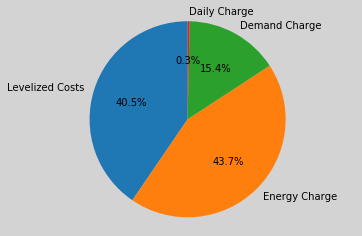

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 210, 95, 21, 56, 51, 0.6499999999999999, 0.8999999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [33.0687, 0.0, 0.0]


ERROR:ga_logger:Cost: 30480.8


ERROR:ga_logger:total demand cost: 4624.615


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 254,965 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,481 per year


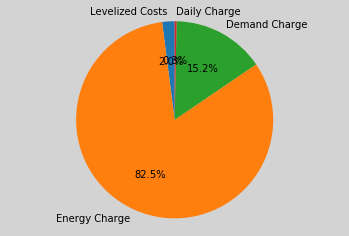

Total roof area of the  building: 4,598 m²
Total roof area used 51 m²
Percentage: 1.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 240, 170, 31, 1, 41, 0.39999999999999997, 0.8999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 41.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.963916540145874 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30227.9


ERROR:ga_logger:total demand cost: 4499.314


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,234 kWh
At a cost of $ 0.0781 /kWh
Total Cost of the system: $ 30,228 per year


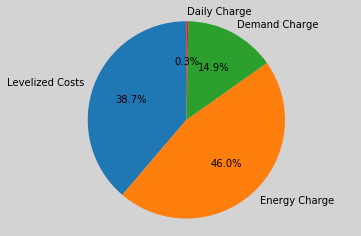

Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 160, 175, 21, 11, 51, 0.44999999999999996, 0.7499999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.900


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.525971174240112 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29617.1


ERROR:ga_logger:total demand cost: 4459.621999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,655 kWh
At a cost of $ 0.0756 /kWh
Total Cost of the system: $ 29,617 per year


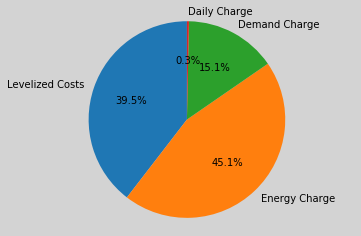

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 130, 100, 11, 16, 11, 0.6499999999999999, 0.8999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.89112114906311 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30066.5


ERROR:ga_logger:total demand cost: 4454.169


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,077 kWh
At a cost of $ 0.0793 /kWh
Total Cost of the system: $ 30,066 per year


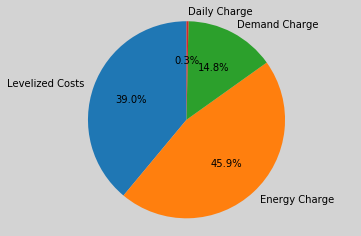

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 115, 205, 36, 46, 51, 0.44999999999999996, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30273.7


ERROR:ga_logger:total demand cost: 4475.2660000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,003 kWh
At a cost of $ 0.0799 /kWh
Total Cost of the system: $ 30,274 per year


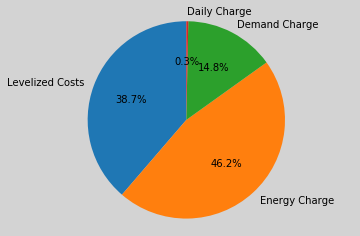

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (195, 230, 145, 1, 1, 56, 0.8999999999999999, 0.44999999999999996, 0.49999999999999994)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [34.613, 0.0, 0.0]


ERROR:ga_logger:Cost: 30484.6


ERROR:ga_logger:total demand cost: 4623.28


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 254,736 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,485 per year


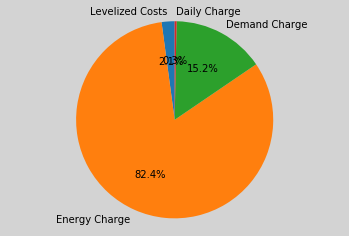

Total roof area of the  building: 4,598 m²
Total roof area used 38 m²
Percentage: 0.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 190, 240, 46, 46, 51, 0.49999999999999994, 0.39999999999999997, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29365.3


ERROR:ga_logger:total demand cost: 4486.317000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,829 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 29,365 per year


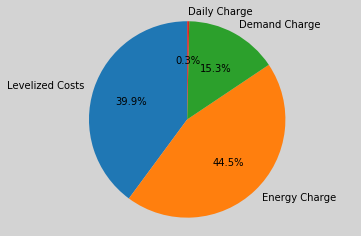

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 185, 100, 41, 21, 56, 0.8999999999999999, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30061.2


ERROR:ga_logger:total demand cost: 4475.461


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,979 kWh
At a cost of $ 0.0783 /kWh
Total Cost of the system: $ 30,061 per year


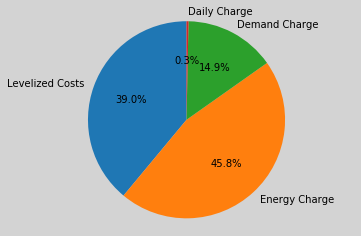

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 694 m²
Percentage: 15.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (195, 170, 220, 16, 31, 31, 0.5499999999999999, 0.8999999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.520612239837646 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29532.6


ERROR:ga_logger:total demand cost: 4463.841


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 181,574 kWh
At a cost of $ 0.0730 /kWh
Total Cost of the system: $ 29,533 per year


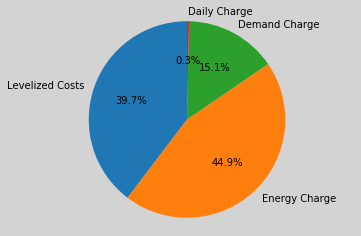

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 110, 205, 31, 21, 6, 0.8499999999999999, 0.8499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.875265836715698 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30181.0


ERROR:ga_logger:total demand cost: 4450.652


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,520 kWh
At a cost of $ 0.0789 /kWh
Total Cost of the system: $ 30,181 per year


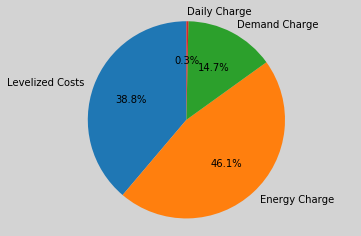

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 145, 90, 36, 36, 31, 0.44999999999999996, 0.5999999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29200.4


ERROR:ga_logger:total demand cost: 4475.419


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,436 kWh
At a cost of $ 0.0753 /kWh
Total Cost of the system: $ 29,200 per year


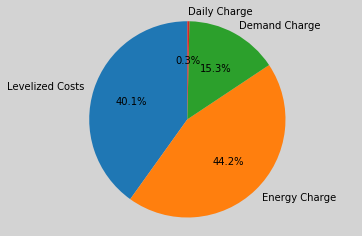

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 120, 125, 31, 26, 21, 0.6499999999999999, 0.3, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29913.8


ERROR:ga_logger:total demand cost: 4458.581999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,394 kWh
At a cost of $ 0.0792 /kWh
Total Cost of the system: $ 29,914 per year


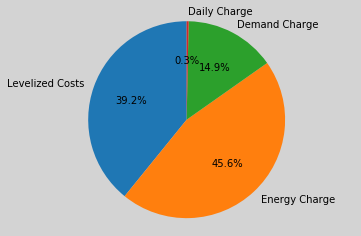

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 100, 110, 31, 1, 1, 0.7, 0.7999999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29519.4


ERROR:ga_logger:total demand cost: 4479.302


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 181,902 kWh
At a cost of $ 0.0727 /kWh
Total Cost of the system: $ 29,519 per year


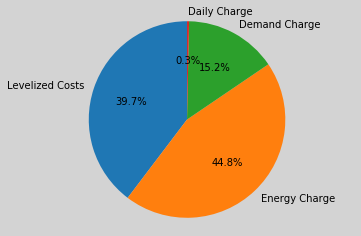

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 125, 215, 1, 46, 41, 0.5499999999999999, 0.3, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.566838026046753 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30374.6


ERROR:ga_logger:total demand cost: 4481.985


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,255 kWh
At a cost of $ 0.0799 /kWh
Total Cost of the system: $ 30,375 per year


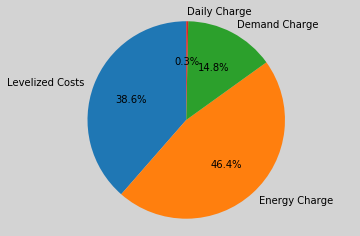

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (90, 250, 130, 21, 11, 46, 0.35, 0.5999999999999999, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 21.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.122962713241577 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29962.9


ERROR:ga_logger:total demand cost: 4478.429


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,700 kWh
At a cost of $ 0.0787 /kWh
Total Cost of the system: $ 29,963 per year


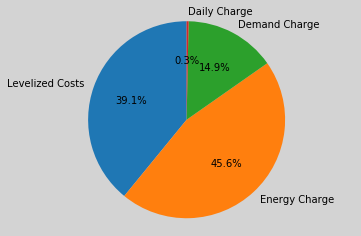

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 105, 185, 26, 46, 1, 0.35, 0.7999999999999998, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 34.6814]


ERROR:ga_logger:Cost: 30484.2


ERROR:ga_logger:total demand cost: 4623.253


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 254,713 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,484 per year


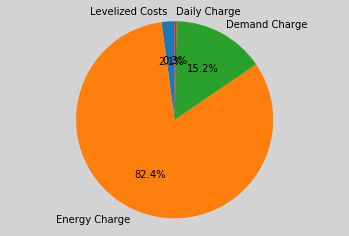

Total roof area of the  building: 4,598 m²
Total roof area used 46 m²
Percentage: 1.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (230, 190, 210, 16, 6, 26, 0.49999999999999994, 0.49999999999999994, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29346.8


ERROR:ga_logger:total demand cost: 4461.329000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,936 kWh
At a cost of $ 0.0743 /kWh
Total Cost of the system: $ 29,347 per year


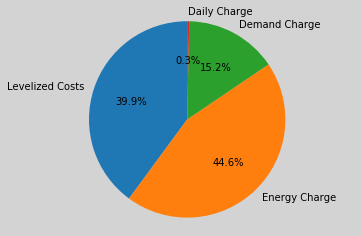

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (230, 265, 95, 56, 46, 21, 0.3, 0.7999999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [14.9371, 0.0, 0.0]


ERROR:ga_logger:Cost: 30500.5


ERROR:ga_logger:total demand cost: 4639.623


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 258,463 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,500 per year


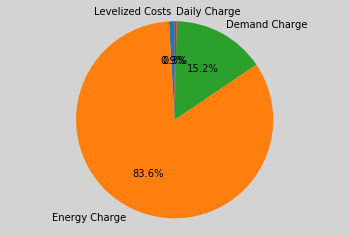

Total roof area of the  building: 4,598 m²
Total roof area used 50 m²
Percentage: 1.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 175, 160, 41, 41, 51, 0.44999999999999996, 0.7499999999999998, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29412.3


ERROR:ga_logger:total demand cost: 4484.386


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,898 kWh
At a cost of $ 0.0768 /kWh
Total Cost of the system: $ 29,412 per year


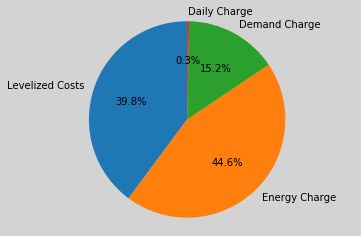

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 120, 110, 46, 6, 1, 0.35, 0.35, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.386866807937622 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29884.0


ERROR:ga_logger:total demand cost: 4484.41


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 181,530 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 29,884 per year


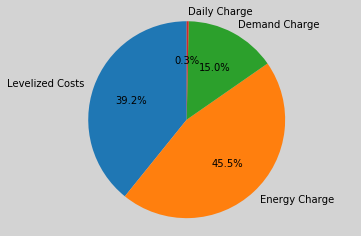

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 130, 155, 56, 26, 56, 0.7, 0.7, 0.8499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.050465822219849 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30403.2


ERROR:ga_logger:total demand cost: 4472.184


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,019 kWh
At a cost of $ 0.0802 /kWh
Total Cost of the system: $ 30,403 per year


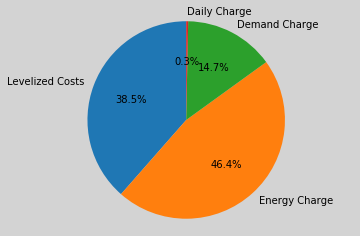

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 180, 220, 41, 6, 36, 0.6499999999999999, 0.2, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29573.4


ERROR:ga_logger:total demand cost: 4468.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,350 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 29,573 per year


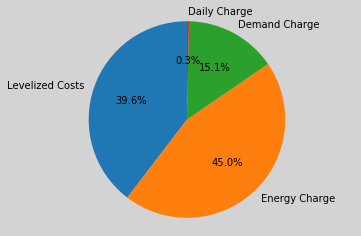

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 230, 135, 51, 11, 1, 0.2, 0.6499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29641.5


ERROR:ga_logger:total demand cost: 4484.6939999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,597 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 29,642 per year


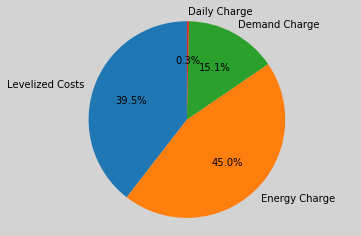

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 120, 215, 21, 16, 56, 0.8499999999999999, 0.5499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30179.0


ERROR:ga_logger:total demand cost: 4456.758


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,535 kWh
At a cost of $ 0.0797 /kWh
Total Cost of the system: $ 30,179 per year


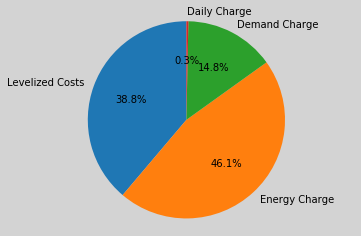

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 110, 205, 56, 36, 21, 0.3, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29871.5


ERROR:ga_logger:total demand cost: 4467.736000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,624 kWh
At a cost of $ 0.0770 /kWh
Total Cost of the system: $ 29,872 per year


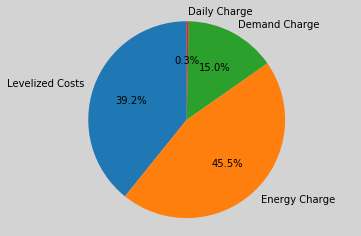

Total roof area of the  building: 4,598 m²
Total roof area used 833 m²
Percentage: 18.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 115, 205, 6, 6, 56, 0.7499999999999998, 0.3, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.632498502731323 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30007.9


ERROR:ga_logger:total demand cost: 4493.004999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,632 kWh
At a cost of $ 0.0759 /kWh
Total Cost of the system: $ 30,008 per year


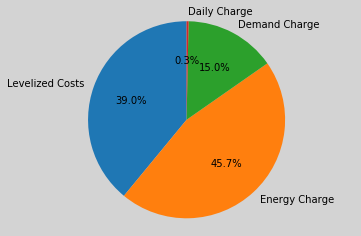

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 125, 250, 26, 31, 26, 0.44999999999999996, 0.7, 0.35)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.324828624725342 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 27.1346]


ERROR:ga_logger:Cost: 30485.0


ERROR:ga_logger:total demand cost: 4626.785


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 256,117 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,485 per year


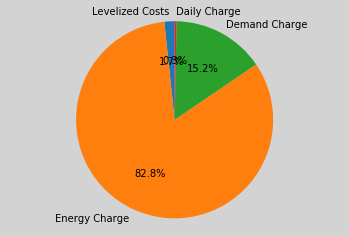

Total roof area of the  building: 4,598 m²
Total roof area used 78 m²
Percentage: 1.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 165, 105, 16, 56, 26, 0.44999999999999996, 0.7499999999999998, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29717.0


ERROR:ga_logger:total demand cost: 4455.529


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,035 kWh
At a cost of $ 0.0782 /kWh
Total Cost of the system: $ 29,717 per year


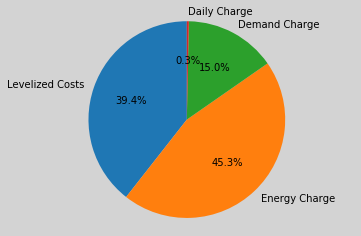

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 195, 155, 6, 21, 41, 0.5999999999999999, 0.7, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29506.1


ERROR:ga_logger:total demand cost: 4481.674


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,938 kWh
At a cost of $ 0.0769 /kWh
Total Cost of the system: $ 29,506 per year


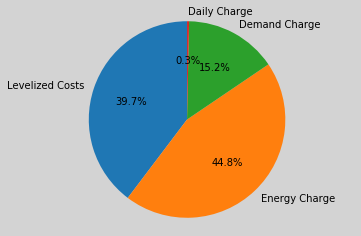

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 155, 125, 36, 21, 1, 0.2, 0.2, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.491430997848511 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29225.6


ERROR:ga_logger:total demand cost: 4456.244


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,530 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,226 per year


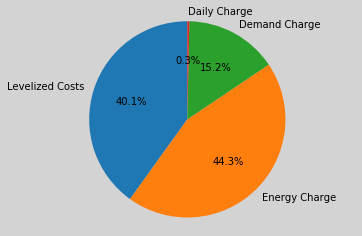

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 160, 255, 1, 11, 1, 0.49999999999999994, 0.35, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 11.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.709425687789917 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29740.5


ERROR:ga_logger:total demand cost: 4452.137


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,205 kWh
At a cost of $ 0.0778 /kWh
Total Cost of the system: $ 29,740 per year


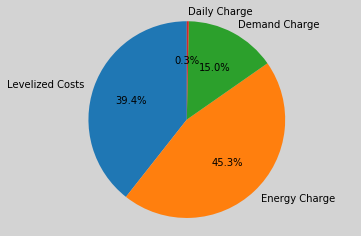

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (90, 255, 135, 46, 11, 21, 0.35, 0.44999999999999996, 0.25)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29572.3


ERROR:ga_logger:total demand cost: 4456.709


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,036 kWh
At a cost of $ 0.0778 /kWh
Total Cost of the system: $ 29,572 per year


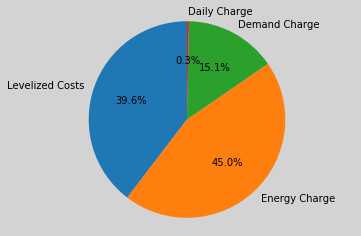

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 190, 235, 6, 26, 36, 0.5499999999999999, 0.3, 0.5499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29043.7


ERROR:ga_logger:total demand cost: 4461.258000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,434 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 29,044 per year


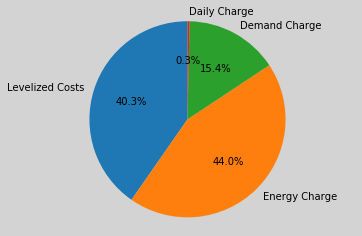

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 230, 200, 31, 16, 6, 0.39999999999999997, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30031.4


ERROR:ga_logger:total demand cost: 4455.723


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,485 kWh
At a cost of $ 0.0771 /kWh
Total Cost of the system: $ 30,031 per year


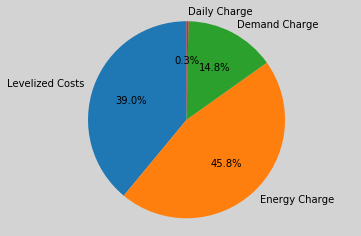

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 95, 135, 1, 21, 21, 0.6499999999999999, 0.39999999999999997, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.775385141372681 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30423.6


ERROR:ga_logger:total demand cost: 4469.852


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,558 kWh
At a cost of $ 0.0801 /kWh
Total Cost of the system: $ 30,424 per year


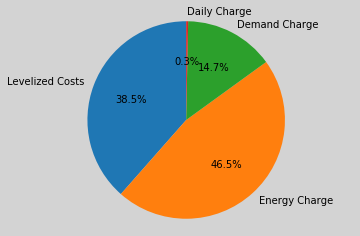

Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 235, 120, 1, 41, 21, 0.7499999999999998, 0.8499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 1.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.322312355041504 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 30049.3


ERROR:ga_logger:total demand cost: 4458.574


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,044 kWh
At a cost of $ 0.0796 /kWh
Total Cost of the system: $ 30,049 per year


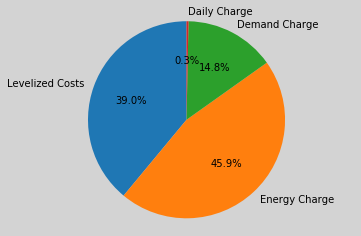

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 120, 225, 41, 41, 21, 0.2, 0.8499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.986726999282837 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28968.8


ERROR:ga_logger:total demand cost: 4473.146


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,674 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 28,969 per year


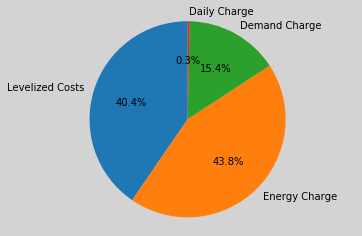

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 235, 125, 21, 16, 36, 0.5999999999999999, 0.5499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30190.3


ERROR:ga_logger:total demand cost: 4456.986


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 182,503 kWh
At a cost of $ 0.0763 /kWh
Total Cost of the system: $ 30,190 per year


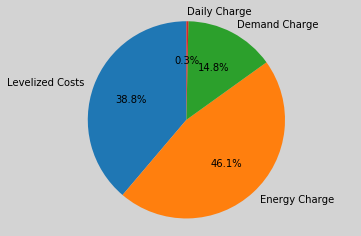

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 245, 125, 21, 21, 1, 0.6499999999999999, 0.8499999999999999, 0.7)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [45.5144, 0.0, 0.0]


ERROR:ga_logger:Cost: 30485.0


ERROR:ga_logger:total demand cost: 4620.869999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 252,704 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,485 per year


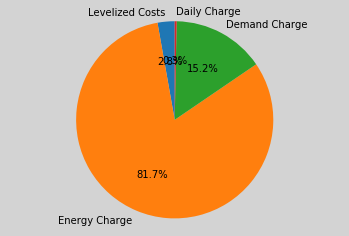

Total roof area of the  building: 4,598 m²
Total roof area used 70 m²
Percentage: 1.5%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 165, 190, 16, 56, 31, 0.7499999999999998, 0.44999999999999996, 0.2)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 12.806122064590454 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 28925.5


ERROR:ga_logger:total demand cost: 4463.719


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,254 kWh
At a cost of $ 0.0734 /kWh
Total Cost of the system: $ 28,926 per year


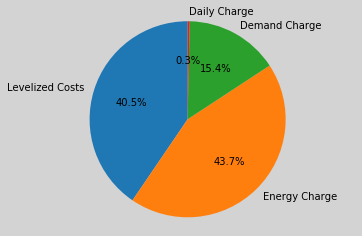

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 245, 165, 11, 21, 16, 0.5999999999999999, 0.5499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29436.3


ERROR:ga_logger:total demand cost: 4455.079000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,438 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 29,436 per year


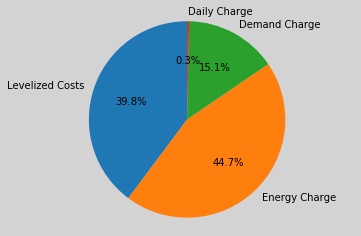

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 135, 150, 26, 1, 31, 0.7999999999999998, 0.7, 0.6499999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29830.7


ERROR:ga_logger:total demand cost: 4476.841


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,236 kWh
At a cost of $ 0.0777 /kWh
Total Cost of the system: $ 29,831 per year


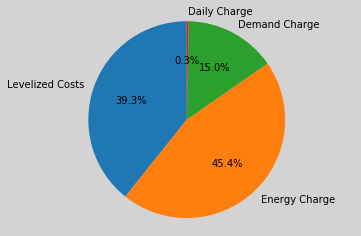

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (265, 245, 110, 11, 16, 11, 0.7, 0.2, 0.44999999999999996)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 30323.0


ERROR:ga_logger:total demand cost: 4453.767000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 231,403 kWh
At a cost of $ 0.0608 /kWh
Total Cost of the system: $ 30,323 per year


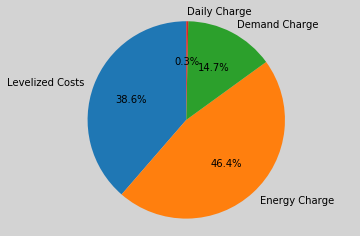

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (260, 265, 220, 51, 26, 36, 0.25, 0.7499999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29763.6


ERROR:ga_logger:total demand cost: 4473.968


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,338 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 29,764 per year


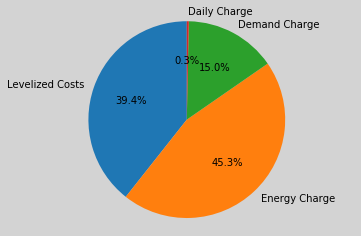

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 140, 180, 31, 1, 26, 0.44999999999999996, 0.8999999999999999, 0.3)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 28995.5


ERROR:ga_logger:total demand cost: 4461.215


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,639 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 28,996 per year


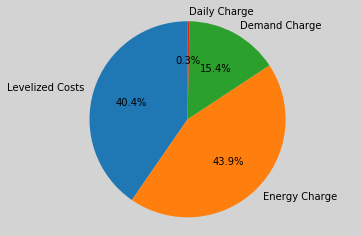

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 175, 175, 21, 21, 1, 0.7499999999999998, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29531.0


ERROR:ga_logger:total demand cost: 4465.73


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,065 kWh
At a cost of $ 0.0762 /kWh
Total Cost of the system: $ 29,531 per year


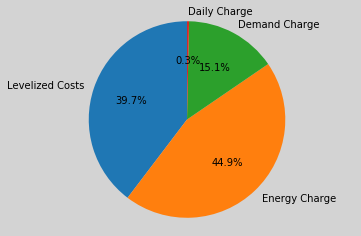

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 195, 130, 31, 16, 21, 0.35, 0.5999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.22932505607605 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28965.5


ERROR:ga_logger:total demand cost: 4466.872


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,356 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 28,966 per year


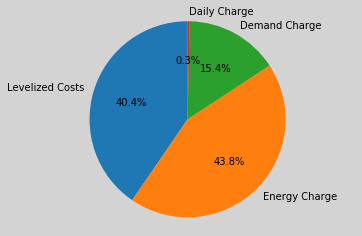

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (220, 245, 195, 31, 6, 21, 0.8499999999999999, 0.5499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29428.8


ERROR:ga_logger:total demand cost: 4462.729


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,429 kWh
At a cost of $ 0.0754 /kWh
Total Cost of the system: $ 29,429 per year


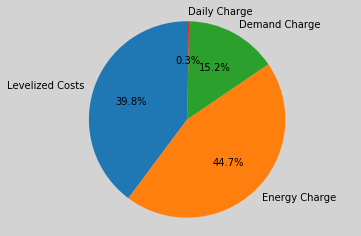

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 200}


Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
20
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      165
azi1      130
azi2      240
tilt0      31
tilt1      36
tilt2      16
gcr0      0.2
gcr1     0.45
gcr2     0.25
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28899.3


ERROR:ga_logger:total demand cost: 4463.599


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,627 kWh
At a cost of $ 0.0744 /kWh
Total Cost of the system: $ 28,899 per year


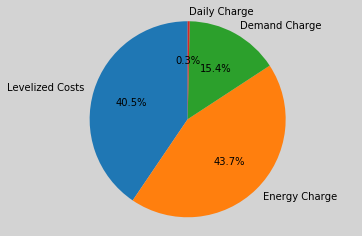

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[165, 130, 240, 31, 36, 16, 0.2, 0.45, 0.25, 28899.3, 625.0, 625.0, 0.0, 0.0, 1, 'red', {'Levelized Costs': 11712.488899999998, 'Energy Charge': 12625.6476, 'Demand Charge': 4463.599, 'Daily Charge': 97.5645}, 133086.7691217998, 169627.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      165
azi1      120
azi2      225
tilt0      41
tilt1      41
tilt2      21
gcr0      0.2
gcr1     0.85
gcr2     0.45
Name: 1, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28968.8


ERROR:ga_logger:total demand cost: 4473.146


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,674 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 28,969 per year


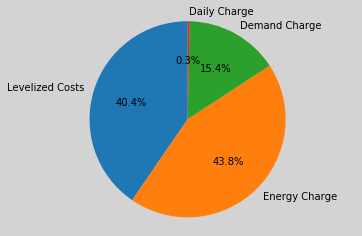

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[165, 120, 225, 41, 41, 21, 0.2, 0.8499999999999999, 0.45, 28968.8, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.4744, 'Energy Charge': 12685.615099999999, 'Demand Charge': 4473.146, 'Daily Charge': 97.5645}, 132478.47095970006, 169674.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      185
azi1      225
azi2      260
tilt0      36
tilt1      46
tilt2      36
gcr0     0.25
gcr1     0.65
gcr2      0.9
Name: 2, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28901.1


ERROR:ga_logger:total demand cost: 4469.465


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,727 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 28,901 per year


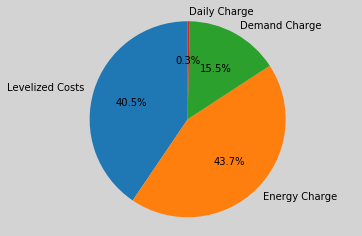

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[185, 225, 260, 36, 46, 36, 0.25, 0.6499999999999999, 0.8999999999999999, 28901.1, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.470499999996, 'Energy Charge': 12621.600000000002, 'Demand Charge': 4469.465, 'Daily Charge': 97.5645}, 133127.59212923402, 171727.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      240
azi2      255
tilt0      26
tilt1       1
tilt2       6
gcr0      0.2
gcr1     0.55
gcr2      0.5
Name: 3, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 49s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28951.3


ERROR:ga_logger:total demand cost: 4459.683


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,263 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 28,951 per year


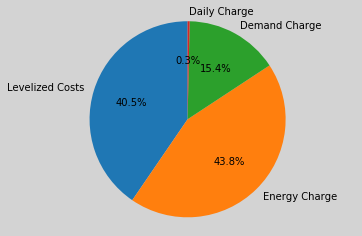

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[180, 240, 255, 26, 1, 6, 0.2, 0.5499999999999999, 0.4999999999999999, 28951.3, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.507199999996, 'Energy Charge': 12681.545300000002, 'Demand Charge': 4459.683, 'Daily Charge': 97.5645}, 132519.8172605, 171263.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      265
azi2      110
tilt0      36
tilt1      56
tilt2      36
gcr0      0.3
gcr1     0.45
gcr2     0.85
Name: 4, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28939.5


ERROR:ga_logger:total demand cost: 4470.759999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,500 kWh
At a cost of $ 0.0738 /kWh
Total Cost of the system: $ 28,940 per year


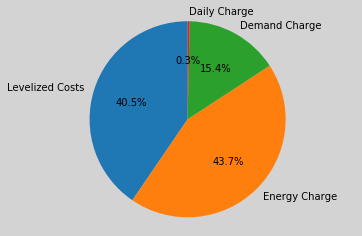

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[180, 265, 110, 36, 56, 36, 0.3, 0.45, 0.8499999999999999, 28939.5, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.5409, 'Energy Charge': 12658.634600000001, 'Demand Charge': 4470.759999999999, 'Daily Charge': 97.5645}, 132752.0794992001, 171500.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      185
azi1      165
azi2      190
tilt0      16
tilt1      56
tilt2      31
gcr0     0.75
gcr1     0.45
gcr2      0.2
Name: 5, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 28925.5


ERROR:ga_logger:total demand cost: 4463.719


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,254 kWh
At a cost of $ 0.0734 /kWh
Total Cost of the system: $ 28,926 per year


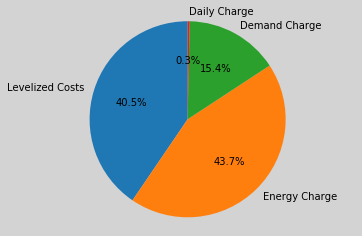

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[185, 165, 190, 16, 56, 31, 0.7499999999999998, 0.45, 0.2, 28925.5, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.5232, 'Energy Charge': 12651.693299999999, 'Demand Charge': 4463.719, 'Daily Charge': 97.5645}, 132822.38569623808, 172254.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      125
azi1      150
azi2      150
tilt0       1
tilt1      31
tilt2      41
gcr0     0.45
gcr1      0.3
gcr2      0.7
Name: 6, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29178.0


ERROR:ga_logger:total demand cost: 4465.575


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,810 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,178 per year


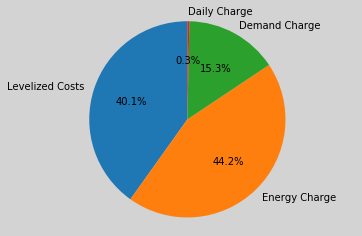

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[125, 150, 150, 1, 31, 41, 0.45, 0.3, 0.7, 29178.0, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.5284, 'Energy Charge': 12902.3321, 'Demand Charge': 4465.575, 'Daily Charge': 97.5645}, 130280.64065762, 169810.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      185
azi1      110
azi2      175
tilt0      11
tilt1      26
tilt2      21
gcr0      0.4
gcr1     0.55
gcr2      0.2
Name: 7, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29113.5


ERROR:ga_logger:total demand cost: 4456.302


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,129 kWh
At a cost of $ 0.0751 /kWh
Total Cost of the system: $ 29,114 per year


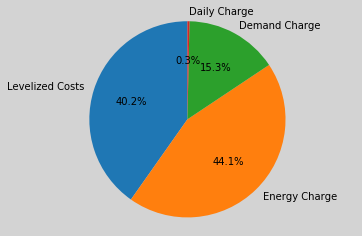

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[185, 110, 175, 11, 26, 21, 0.4, 0.5499999999999999, 0.2, 29113.5, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.487300000003, 'Energy Charge': 12847.146199999997, 'Demand Charge': 4456.302, 'Daily Charge': 97.5645}, 130840.08653764, 171129.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      195
azi2      130
tilt0      31
tilt1      16
tilt2      21
gcr0     0.35
gcr1      0.6
gcr2      0.8
Name: 8, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 28965.5


ERROR:ga_logger:total demand cost: 4466.872


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,356 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 28,966 per year


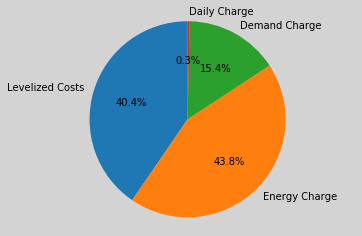

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
[[180, 195, 130, 31, 16, 21, 0.35, 0.5999999999999999, 0.7999999999999998, 28965.5, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.534800000001, 'Energy Charge': 12688.528699999999, 'Demand Charge': 4466.872, 'Daily Charge': 97.5645}, 132448.82669860026, 171356.0, 1785.71]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      125
azi1      220
azi2      175
tilt0      51
tilt1      16
tilt2      26
gcr0      0.7
gcr1     0.55
gcr2      0.4
Name: 9, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29058.5


ERROR:ga_logger:total demand cost: 4463.089000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,246 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 29,058 per year


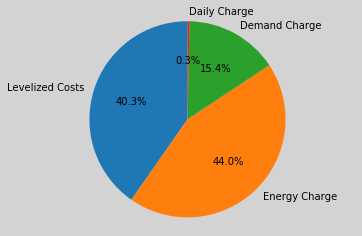

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
[[125, 220, 175, 51, 16, 26, 0.7, 0.5499999999999999, 0.4, 29058.5, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.555, 'Energy Charge': 12785.291499999998, 'Demand Charge': 4463.089000000001, 'Daily Charge': 97.5645}, 131467.4957963, 171246.0, 1562.5]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      140
azi1      140
azi2      180
tilt0      31
tilt1       1
tilt2      26
gcr0     0.45
gcr1      0.9
gcr2      0.3
Name: 10, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 28995.5


ERROR:ga_logger:total demand cost: 4461.215


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,639 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 28,996 per year


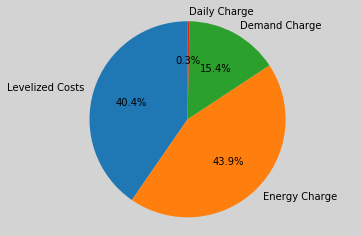

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[140, 140, 180, 31, 1, 26, 0.45, 0.8999999999999999, 0.3, 28995.5, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.490299999998, 'Energy Charge': 12724.230200000002, 'Demand Charge': 4461.215, 'Daily Charge': 97.5645}, 132086.78916729998, 171639.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      150
azi1      170
azi2      120
tilt0      21
tilt1      11
tilt2      46
gcr0     0.25
gcr1     0.35
gcr2     0.55
Name: 11, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29305.2


ERROR:ga_logger:total demand cost: 4456.7429999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,463 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 29,305 per year


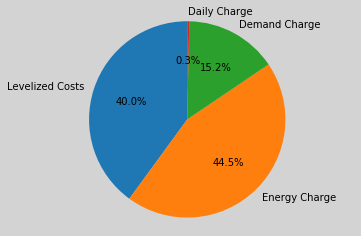

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[150, 170, 120, 21, 11, 46, 0.25, 0.35, 0.5499999999999999, 29305.2, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.504, 'Energy Charge': 13038.3885, 'Demand Charge': 4456.7429999999995, 'Daily Charge': 97.5645}, 128900.6748216281, 170463.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      225
azi1      170
azi2      150
tilt0      26
tilt1      36
tilt2      11
gcr0     0.55
gcr1     0.45
gcr2     0.75
Name: 12, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 107s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29147.4


ERROR:ga_logger:total demand cost: 4475.444


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,421 kWh
At a cost of $ 0.0750 /kWh
Total Cost of the system: $ 29,147 per year


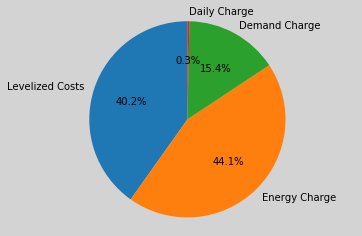

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[225, 170, 150, 26, 36, 11, 0.5499999999999999, 0.45, 0.7499999999999998, 29147.4, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.529500000004, 'Energy Charge': 12861.861999999997, 'Demand Charge': 4475.444, 'Daily Charge': 97.5645}, 130690.8410803, 171421.0, 1388.89]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      165
azi1      175
azi2      185
tilt0      46
tilt1      11
tilt2       6
gcr0     0.25
gcr1      0.5
gcr2      0.5
Name: 13, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29186.1


ERROR:ga_logger:total demand cost: 4480.34


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,588 kWh
At a cost of $ 0.0756 /kWh
Total Cost of the system: $ 29,186 per year


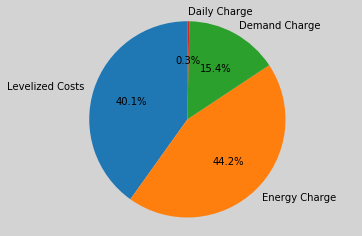

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[165, 175, 185, 46, 11, 6, 0.25, 0.4999999999999999, 0.4999999999999999, 29186.1, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.515099999997, 'Energy Charge': 12895.680400000001, 'Demand Charge': 4480.34, 'Daily Charge': 97.5645}, 130347.92139570025, 170588.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      105
azi2      255
tilt0      26
tilt1       6
tilt2      46
gcr0      0.4
gcr1      0.3
gcr2     0.75
Name: 14, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29060.9


ERROR:ga_logger:total demand cost: 4463.108


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,590 kWh
At a cost of $ 0.0745 /kWh
Total Cost of the system: $ 29,061 per year


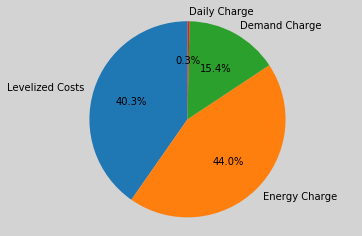

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
[[180, 105, 255, 26, 6, 46, 0.4, 0.3, 0.7499999999999998, 29060.9, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.5215, 'Energy Charge': 12787.706, 'Demand Charge': 4463.108, 'Daily Charge': 97.5645}, 131443.00494719992, 171590.0, 1562.5]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0     135
azi1     155
azi2     125
tilt0     36
tilt1     21
tilt2      1
gcr0     0.2
gcr1     0.2
gcr2     0.7
Name: 15, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29225.6


ERROR:ga_logger:total demand cost: 4456.244


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,530 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 29,226 per year


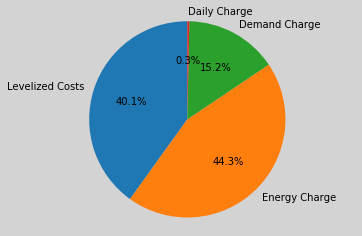

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[135, 155, 125, 36, 21, 1, 0.2, 0.2, 0.7, 29225.6, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.4659, 'Energy Charge': 12959.3256, 'Demand Charge': 4456.244, 'Daily Charge': 97.5645}, 129702.40087689982, 170530.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      110
azi1      190
azi2      235
tilt0       6
tilt1      26
tilt2      36
gcr0     0.55
gcr1      0.3
gcr2     0.55
Name: 16, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29043.7


ERROR:ga_logger:total demand cost: 4461.258000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,434 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 29,044 per year


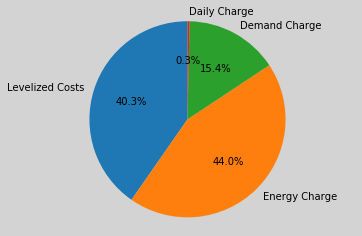

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[110, 190, 235, 6, 26, 36, 0.5499999999999999, 0.3, 0.5499999999999999, 29043.7, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.446200000002, 'Energy Charge': 12772.431299999998, 'Demand Charge': 4461.258000000001, 'Daily Charge': 97.5645}, 131598.08625850896, 172434.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      175
azi1      145
azi2      130
tilt0      51
tilt1      41
tilt2      56
gcr0      0.5
gcr1      0.3
gcr2     0.45
Name: 17, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 29465.8


ERROR:ga_logger:total demand cost: 4476.130999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,679 kWh
At a cost of $ 0.0772 /kWh
Total Cost of the system: $ 29,466 per year


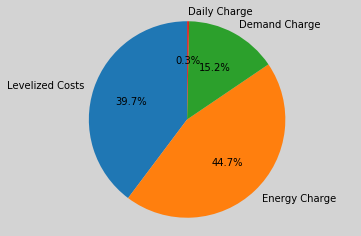

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[175, 145, 130, 51, 41, 56, 0.4999999999999999, 0.3, 0.45, 29465.8, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.509999999998, 'Energy Charge': 13179.594500000001, 'Demand Charge': 4476.130999999999, 'Daily Charge': 97.5645}, 127468.56073685028, 170679.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      115
azi1      175
azi2      160
tilt0      41
tilt1      41
tilt2      51
gcr0     0.45
gcr1     0.75
gcr2      0.2
Name: 18, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 29412.3


ERROR:ga_logger:total demand cost: 4484.386


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,898 kWh
At a cost of $ 0.0768 /kWh
Total Cost of the system: $ 29,412 per year


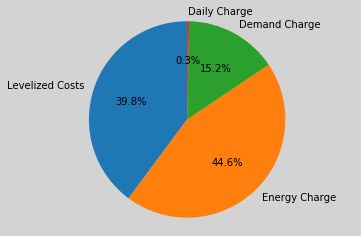

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[115, 175, 160, 41, 41, 51, 0.45, 0.7499999999999998, 0.2, 29412.3, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 11712.481899999997, 'Energy Charge': 13117.867600000001, 'Demand Charge': 4484.386, 'Daily Charge': 97.5645}, 128094.69401239998, 170898.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      165
azi1      145
azi2       90
tilt0      36
tilt1      36
tilt2      31
gcr0     0.45
gcr1      0.6
gcr2      0.3
Name: 19, dtype: object


ERROR:ga_logger:price of the panel 200


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 105s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 29200.4


ERROR:ga_logger:total demand cost: 4475.419


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,436 kWh
At a cost of $ 0.0753 /kWh
Total Cost of the system: $ 29,200 per year


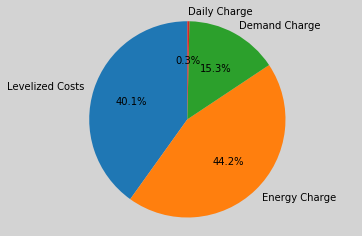

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[165, 145, 90, 36, 36, 31, 0.45, 0.5999999999999999, 0.3, 29200.4, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 11712.4634, 'Energy Charge': 12914.9531, 'Demand Charge': 4475.419, 'Daily Charge': 97.5645}, 130152.47017079998, 171436.0, 1388.89]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_proc)